In [37]:
%load_ext autoreload
%autoreload 2
from sympy import symbols, init_printing, simplify, solve, factor, srepr, Add, Symbol, Integer
from mako.template import Template
from mako.lookup import TemplateLookup
from mako.runtime import Context
from StringIO import StringIO
from fdlib import *
init_printing()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
U,V,W,Txx,Tyy,Tzz,Txy,Tyz,Txz = IndexedBases('U V W Txx Tyy Tzz Txy Tyz Txz')
b, lam, mu = IndexedBases('beta lambda mu')
x,y,z,t,h,dt = symbols('x y z t h dt')

In [3]:
accuracy_time = 1 # O(dt^2) accuracy in time domain
accuracy_space = 2 # O(h^4) accuracy in space domain

In [4]:
l = [x,y,z,t]

# first-order time derivatives in velocities and stresses
# O(dt^2) accuracy
DtU = Deriv_half(U,l,3,dt,accuracy_time)[1]
DtV = Deriv_half(V,l,3,dt,accuracy_time)[1]
DtW = Deriv_half(W,l,3,dt,accuracy_time)[1]

DtTxx = Deriv_half(Txx,l,3,dt,accuracy_time)[1]
DtTxy = Deriv_half(Txy,l,3,dt,accuracy_time)[1]
DtTxz = Deriv_half(Txz,l,3,dt,accuracy_time)[1]
DtTyy = Deriv_half(Tyy,l,3,dt,accuracy_time)[1]
DtTyz = Deriv_half(Tyz,l,3,dt,accuracy_time)[1]
DtTzz = Deriv_half(Tzz,l,3,dt,accuracy_time)[1]

# first-order spacial derivatives of velocities and stresses
# O(h^4) accuracy

DxU = Deriv_half(U,l,0,h,accuracy_space,shift_forward=False)[1]
DyU = Deriv_half(U,l,1,h,accuracy_space,shift_forward=False)[1]
DzU = Deriv_half(U,l,2,h,accuracy_space,shift_forward=False)[1]

DxV = Deriv_half(V,l,0,h,accuracy_space,shift_forward=False)[1]
DyV = Deriv_half(V,l,1,h,accuracy_space,shift_forward=False)[1]
DzV = Deriv_half(V,l,2,h,accuracy_space,shift_forward=False)[1]

DxW = Deriv_half(W,l,0,h,accuracy_space,shift_forward=False)[1]
DyW = Deriv_half(W,l,1,h,accuracy_space,shift_forward=False)[1]
DzW = Deriv_half(W,l,2,h,accuracy_space,shift_forward=False)[1]

DxTxx = Deriv_half(Txx,l,0,h,accuracy_space)[1]
DyTyy = Deriv_half(Tyy,l,1,h,accuracy_space)[1]
DzTzz = Deriv_half(Tzz,l,2,h,accuracy_space)[1]

DxTxy = Deriv_half(Txy,l,0,h,accuracy_space,shift_forward=False)[1]
DyTxy = Deriv_half(Txy,l,1,h,accuracy_space,shift_forward=False)[1]
DyTyz = Deriv_half(Tyz,l,1,h,accuracy_space,shift_forward=False)[1]
DzTyz = Deriv_half(Tyz,l,2,h,accuracy_space,shift_forward=False)[1]
DxTxz = Deriv_half(Txz,l,0,h,accuracy_space,shift_forward=False)[1]
DzTxz = Deriv_half(Txz,l,2,h,accuracy_space,shift_forward=False)[1]

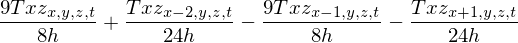

In [5]:
DxTxz

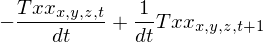

In [6]:
DtTxx

In [11]:
t_2, t_1, t0, t1 = symbols('t_2 t_1 t0 t1')
replace_t = {t-2:t_2, t-1:t_1, t+1:t1}

In [71]:
# momentum equations
# replace t index with symbols (static for loop implementation)
eq1 = Eq(DtU, b[x,y,z]*(DxTxx + DyTxy + DzTxz)).xreplace(replace_t)
eq2 = Eq(DtV, b[x,y,z]*(DxTxy + DyTyy + DzTyz)).xreplace(replace_t)
eq3 = Eq(DtW, b[x,y,z]*(DxTxz + DyTyz + DzTzz)).xreplace(replace_t)

# stress-strain equations
eq4 = Eq(DtTxx, (lam[x,y,z] + 2*mu[x,y,z])*DxU + lam[x,y,z]*(DyV+DzW)).xreplace(replace_t)
eq5 = Eq(DtTyy, (lam[x,y,z] + 2*mu[x,y,z])*DyV + lam[x,y,z]*(DxU+DzW)).xreplace(replace_t)
eq6 = Eq(DtTzz, (lam[x,y,z] + 2*mu[x,y,z])*DzW + lam[x,y,z]*(DxU+DyV)).xreplace(replace_t)
eq7 = Eq(DtTxy, mu[x,y,z]*(DyU+DxV)).xreplace(replace_t)
eq8 = Eq(DtTxz, mu[x,y,z]*(DzU+DxW)).xreplace(replace_t)
eq9 = Eq(DtTyz, mu[x,y,z]*(DzV+DyW)).xreplace(replace_t)

In [69]:
eq1 = Eq(eq1.lhs, eq1.rhs.xreplace({t:t1}))
eq2 = Eq(eq2.lhs, eq2.rhs.xreplace({t:t1}))
eq3 = Eq(eq3.lhs, eq3.rhs.xreplace({t:t1}))

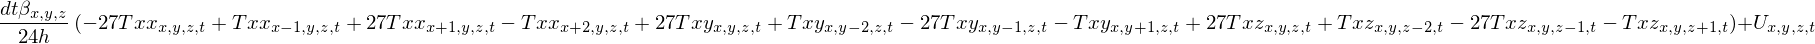

In [72]:
simplify(solve(eq1,U[x,y,z,t1])[0]-U[x,y,z,t])+U[x,y,z,t]

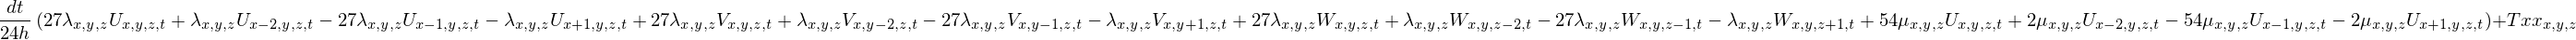

In [61]:
simplify(solve(eq4,Txx[x,y,z,t1])[0]-Txx[x,y,z,t])+Txx[x,y,z]

In [62]:
U_t = print_assignment(eq1, U[x,y,z,t1], U[x,y,z,t])
V_t = print_assignment(eq2, V[x,y,z,t1], V[x,y,z,t])
W_t = print_assignment(eq3, W[x,y,z,t1], W[x,y,z,t])
Txx_t = print_assignment(eq4, Txx[x,y,z,t1], Txx[x,y,z,t])
Tyy_t = print_assignment(eq5, Tyy[x,y,z,t1], Tyy[x,y,z,t])
Tzz_t = print_assignment(eq6, Tzz[x,y,z,t1], Tzz[x,y,z,t])
Txy_t = print_assignment(eq7, Txy[x,y,z,t1], Txy[x,y,z,t])
Txz_t = print_assignment(eq8, Txz[x,y,z,t1], Txz[x,y,z,t])
Tyz_t = print_assignment(eq9, Tyz[x,y,z,t1], Tyz[x,y,z,t])

In [63]:
Txx_t

'Txx[x][y][z][t1]=(1.0F/24.0F)*dt*(27*lambda[x][y][z]*U[x][y][z][t] + lambda[x][y][z]*U[x - 2][y][z][t] - 27*lambda[x][y][z]*U[x - 1][y][z][t] - lambda[x][y][z]*U[x + 1][y][z][t] + 27*lambda[x][y][z]*V[x][y][z][t] + lambda[x][y][z]*V[x][y - 2][z][t] - 27*lambda[x][y][z]*V[x][y - 1][z][t] - lambda[x][y][z]*V[x][y + 1][z][t] + 27*lambda[x][y][z]*W[x][y][z][t] + lambda[x][y][z]*W[x][y][z - 2][t] - 27*lambda[x][y][z]*W[x][y][z - 1][t] - lambda[x][y][z]*W[x][y][z + 1][t] + 54*mu[x][y][z]*U[x][y][z][t] + 2*mu[x][y][z]*U[x - 2][y][z][t] - 54*mu[x][y][z]*U[x - 1][y][z][t] - 2*mu[x][y][z]*U[x + 1][y][z][t])/h + Txx[x][y][z][t]'

In [67]:
U_t

'U[x][y][z][t1]=(1.0F/24.0F)*dt*(-27*Txx[x][y][z][t1] + Txx[x - 1][y][z][t1] + 27*Txx[x + 1][y][z][t1] - Txx[x + 2][y][z][t1] + 27*Txy[x][y][z][t1] + Txy[x][y - 2][z][t1] - 27*Txy[x][y - 1][z][t1] - Txy[x][y + 1][z][t1] + 27*Txz[x][y][z][t1] + Txz[x][y][z - 2][t1] - 27*Txz[x][y][z - 1][t1] - Txz[x][y][z + 1][t1])*beta[x][y][z]/h + U[x][y][z][t]'

In [65]:
mylookup = TemplateLookup(directories=['templates/'])
mytemplate = mylookup.get_template('test_ref_iso_elastic_tmpl.cpp')
buf = StringIO()
dict1 = {'time_period':2,'Txx':Txx_t,'Tyy':Tyy_t,'Tzz':Tzz_t,'Txy':Txy_t,'Txz':Txz_t,'Tyz':Tyz_t,'U':U_t,'V':V_t,'W':W_t}
ctx = Context(buf, **dict1)
mytemplate.render_context(ctx)
code = buf.getvalue()

In [66]:
f= open('../tests/src/mytest1.cpp','w')
f.write(code)
f.close()